In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Subset

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, 
                                      download=True, transform=transform)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                     download=True, transform=transform)

trainset_sub = Subset(trainset, indices=range(6400))
testset_sub = Subset(testset, indices=range(1000))

trainloader = torch.utils.data.DataLoader(trainset_sub, batch_size=4,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset_sub, batch_size=4,
                                          shuffle=True, num_workers=2)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
class model_fashionMNIST(nn.Module):
    def __init__(self):
        super(model_fashionMNIST, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(4 * 4 * 16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.loss_fn = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
    
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.reshape(x.shape[0], 4 * 4 * 16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def train(self, batches):
        losses = []
        for epoch in range(2):
            running_loss = 0.0
            for i, batch in enumerate(batches):
                X_batch, y_batch = batch   

                self.optimizer.zero_grad()
            
                y_pred = self.forward(X_batch)
                loss = self.loss_fn(y_pred, y_batch)
                loss.backward()
                self.optimizer.step()
            
                running_loss += loss.item()
            
                if i % 200 == 199:
                    print('{} loss: {}'.format(i + 1 + epoch * 1600, 
                                               round(running_loss / 200, 
                                                     3)))
                    losses.append(running_loss)
                    running_loss = 0.0 
                
        plt.plot(np.arange(len(losses)), losses)
        plt.show()
        print('train ended')
        
    def test(self, data):
        class_correct = list(0 for i in range(10))
        class_total = list(0 for i in range(10))
        classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
                   'Shirt', 'Sneaker', 'Bag', 'Ankle boot')
        
        with torch.no_grad():
            for i, batch in enumerate(data):
                images, labels = batch
                y_pred = self.forward(images)
                _, predicted = torch.max(y_pred, 1)
                
                checker = (predicted.detach() == labels)
                
                for i in range(4):
                    label = labels[i]
                    class_correct[label] += checker[i].item()
                    class_total[label] += 1
                if i == 999:
                    break
                    
        for idx, name_class in enumerate(classes):
            print('Accuracy of {}: {}'.format(name_class, round(class_correct[idx] / class_total[idx] * 100, 3)))
        
        print('Mean accuracy = {}'.format(sum(class_correct) / sum(class_total) * 100))

In [ ]:
class rankStochasticPool(nn.Module):
    def __init__(self, kernel_size, stride, padding = 0, alpha = 0.5):
        super(rankStochasticPool, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        probas = []
        for rank in range(kernel_size ** 2):
            probas.append(alpha * (1 - alpha) ** rank)
        self.probas = torch.Tensor(probas)
    
    def forward(self, x):
        x = F.pad(x, (self.padding, self.padding, self.padding, self.padding))
        n_imgs = x.shape[0]
        n_channels = x.shape[1]
        n_height = x.shape[2]
        n_width = x.shape[3]
        
        x_unfold = F.unfold(x, kernel_size=self.kernel_size, stride=self.stride)
        
        n_regions = x_unfold.shape[-1]
        n_regions_side = int(np.sqrt(n_regions))
        
        x_unfold = x_unfold.view(n_imgs, 
                                 n_channels, 
                                 self.kernel_size, 
                                 self.kernel_size, 
                                 n_regions).permute(0, 4, 1, 2, 3).view(n_imgs, 
                                                                        n_regions, 
                                                                        n_channels, 
                                                                        self.kernel_size ** 2)
        
        probas = torch.cat([self.probas] * (n_imgs * n_channels * n_regions)).view(n_imgs, 
                                                                                   n_regions, 
                                                                                   n_channels, 
                                                                                   self.kernel_size ** 2)
        
        output = torch.zeros((n_imgs, n_channels, n_height // self.stride, n_width // self.stride))

        for idx_i, img in enumerate(x_unfold):
            for idx_r, region in enumerate(img):
                for idx_c, channel in enumerate(region):
                    idx = torch.multinomial(probas[idx_i][idx_r][idx_c], 1)
                    val = channel[int(idx)]
                    output[idx_i][idx_c][idx_r // n_regions_side][idx_r % n_regions_side] = val

        return output

In [ ]:
class model_fashionMNIST_rankStochasticPool(model_fashionMNIST):
    def __init__(self):
        super(model_fashionMNIST_rankStochasticPool, self).__init__()
        self.pool1 = rankStochasticPool(2, 2)
        self.pool2 = rankStochasticPool(2, 2)

200 loss: 2.293
400 loss: 1.998
600 loss: 1.287
800 loss: 1.017
1000 loss: 0.959
1200 loss: 0.925
1400 loss: 0.899
1600 loss: 0.879
1800 loss: 0.874
2000 loss: 0.816
2200 loss: 0.801
2400 loss: 0.79
2600 loss: 0.756
2800 loss: 0.788
3000 loss: 0.766
3200 loss: 0.811


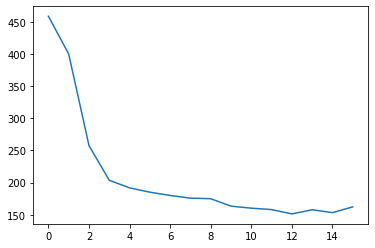

train ended


In [ ]:
m9_RSP = model_fashionMNIST_rankStochasticPool()
m9_RSP.train(trainloader)

In [ ]:
m9_RSP.test(testloader)

Accuracy of T-shirt/top: 74.766
Accuracy of Trouser: 94.286
Accuracy of Pullover: 42.342
Accuracy of Dress: 61.29
Accuracy of Coat: 71.304
Accuracy of Sandal: 72.414
Accuracy of Shirt: 27.835
Accuracy of Sneaker: 83.158
Accuracy of Bag: 87.368
Accuracy of Ankle boot: 92.632
Mean accuracy = 70.5
